# Experiment 1 Enhanced: Optimized Prompt Engineering on Non-Fine-Tuned Large Language Model

## Objective
This experiment aims to evaluate the performance of a state-of-the-art language model using advanced prompt engineering techniques, to maximize the performance of a non-fine-tuned language model. The primary goal is to systematically evaluate multiple prompting approaches and identify techniques that yield superior results without altering model parameters.

## Experimental Setup

### Model Specifications
- **Architecture:** Meta's Llama 3.1 Instruct
- **Source:** Unsloth HuggingFace model repository (instruction-tuned variant)

### Computational Environment
- **Platform:** Google Colab Notebook
- **Infrastructure Tier:** Free or Pro
- **GPU Specification:** NVIDIA Tesla T4 or A100

### Dataset
- **Corpus:** google-research-datasets/Disfl-QA

## Methodology
The experiment employs advanced prompt engineering techniques including few-shot learning with diverse examples, optimized sampling parameters, and systematic comparison of multiple prompting strategies. This approach aims to elicit optimal performance from the instruction-tuned Llama 3.1 model without fine-tuning.

## Evaluation Metrics
To quantify the model's performance, I utilize widely recognized natural language processing metrics:

1. **BLEU Score (Bilingual Evaluation Understudy)**
2. **ROUGE Score (Recall-Oriented Understudy for Gisting Evaluation)**
3. **Exact Match Rate**

These metrics provide a comprehensive evaluation of the model's linguistic accuracy and relevance in the context of the Disfl-QA dataset.

In [1]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install evaluate rouge_score

from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton

Step 2: Loading the data

In [2]:
import requests
import pandas as pd
import json

def process_github_json_files(base_url, file_names):
    dataframes = {}

    for file_name in file_names:
        url = f"{base_url}/{file_name}"
        try:
            response = requests.get(url)
            if response.status_code != 200:
                raise Exception(f"Failed to download {file_name}. Status code: {response.status_code}")

            data = json.loads(response.text)
            df = pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'id'})

            output_file = f"{file_name}"
            df.to_json(output_file, orient='records')

            key = file_name.split('.')[0]
            dataframes[key] = df

        except Exception as e:
            print(f"An error occurred while processing {file_name}: {str(e)}")

    return dataframes.get('train'), dataframes.get('test'), dataframes.get('dev')

base_url = "https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/master"
file_names = ["train.json", "test.json", "dev.json"]

df_train, df_test, df_dev = process_github_json_files(base_url, file_names)

In [3]:
print("Shape of train DataFrame:", df_train.shape if df_train is not None else "Not available")
print("Shape of test DataFrame:", df_test.shape if df_test is not None else "Not available")
print("Shape of dev DataFrame:", df_dev.shape if df_dev is not None else "Not available")

Shape of train DataFrame: (7182, 3)
Shape of test DataFrame: (3643, 3)
Shape of dev DataFrame: (1000, 3)


In [4]:
df_train.head(5)

,id,original,disfluent
0,5a5918ff3e1742001a15cf7e,What do unstable isotope studies indicate?,What do petrologists no what do unstable isoto...
1,5ad4f40c5b96ef001a10a774,What is the basic unit of territorial division...,What is the second level of territorial divisi...
2,572684365951b619008f7543,Which genus lack tentacles and sheaths?,Juvenile platyctenids no wow Which genus lack ...
3,5729f799af94a219006aa70a,Long-lived memory cells can remember previous ...,When a pathogen is met again scratch that I me...
4,5ad3b9cd604f3c001a3fee87,What led to Newcastle's rise to power as milit...,What led to the Duke of Cumberland's rise to p...


## Step 3: Load Llama 3.1 Instruct Model

In this experiment, I utilize the instruction-tuned variant of Llama 3.1, which has been specifically optimized to follow instructions more accurately than the base model. This architectural choice aims to improve the model's responsiveness to prompt engineering techniques.

In [5]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.1: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRM

## Step 4: Build Prompts with Multiple Strategies

## Prompt Engineering Methodology

### Approach Overview
In this research project, I explored multiple approaches for constructing effective prompts to optimize the performance of the language model. The primary methodologies employed were:

1. Zero-shot learning
2. Few-shot learning with varying numbers of examples

I conducted extensive experimentation with various prompt structures and content to identify the most effective formulations.

### Key Challenge
A significant challenge encountered during the prompt engineering process was instructing the model to output only the corrected question without generating extraneous explanations or hallucinated examples.

### Iterative Process
Through multiple iterations of prompt engineering, I developed several template variations that were systematically evaluated. Each template was designed to address specific aspects of the task:
- Reduced hallucinations
- Outputs constrained to corrected questions only
- Improved handling of diverse disfluency types

### Few-Shot Learning Strategy
The few-shot approach incorporates examples representing different categories of disfluencies, including word substitutions, phrase corrections, filler word removal, and question word changes. This diversity aims to provide the model with comprehensive pattern recognition across the full spectrum of disfluency types present in the dataset.

### Alternative Approaches
For context, it's worth noting that alternative methods such as fine-tuning can be employed to instruct the model to output in a specific format. These alternative approaches are demonstrated in Experiment 2 and Experiment 3, detailed in separate notebooks.

In [6]:
instruction_template = '''
You are an AI assistant that corrects disfluent questions.
Remove all disfluencies (filler words, false starts, hesitations, repetitions) and output a single, fluent, clear, and concise version of the input question.
Maintain the original meaning and intent. Use natural, formal English.
Do not change the subject, alter the question's meaning, or add any new information.
Provide only the corrected question as a single line, without explanations, examples, or additional formatting.
'''

prompt_zero_shot = '''
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

{instruction}

Disfluent Question:
{disfluent_question}

Corrected Question based on the above instructions, Important dont add explanations, examples, or additional formatting:
'''

few_shot_examples_5 = '''Example 1:
Disfluent: What French no British General negotiated at Montreal?
Corrected: What British General negotiated at Montreal?

Example 2:
Disfluent: What is the second level no wait the basic unit of territorial division in Warsaw?
Corrected: What is the basic unit of territorial division in Warsaw?

Example 3:
Disfluent: Who did no What did the government want Thoreau to do?
Corrected: What did the government want Thoreau to do?

Example 4:
Disfluent: What dynasties reflected no inspired the Chinese-like elements of the Yuan dynasty?
Corrected: What dynasties inspired the Chinese-like elements of the Yuan dynasty?

Example 5:
Disfluent: When or uh what did European empires rely on to supply their labor needs?
Corrected: What did European empires rely on to supply their labor needs?'''

prompt_few_shot_5 = '''
Below is an instruction that describes a task, paired with examples and an input.

### Instruction:
{instruction}

### Examples:
{examples}

### Input:
{disfluent_question}

### Output (corrected question only):
'''

## Step 5: Define Inference Function with Optimized Parameters

The inference function incorporates several parameter optimizations to improve output quality and consistency. These include adjusted temperature settings for more deterministic outputs, repetition penalty to reduce redundant text generation, and post-processing steps to extract clean responses.

In [7]:
def generate_prediction(disfluent_input, prompt_template, examples=None):
    if examples is not None:
        prompt = prompt_template.format(
            instruction=instruction_template,
            disfluent_question=disfluent_input,
            examples=examples
        )
    else:
        prompt = prompt_template.format(
            instruction=instruction_template,
            disfluent_question=disfluent_input
        )

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    output_tokens = model.generate(
        **inputs,
        max_new_tokens=64,
        temperature=0.1,
        do_sample=False,
        repetition_penalty=1.1,
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id,
    )

    output_text = tokenizer.batch_decode(
        output_tokens[:, len(inputs[0].tokens):],
        skip_special_tokens=True
    )[0]

    output_text = output_text.split('\n')[0].strip()

    return output_text

## Step 6: Test Prompt Strategies on Single Example

Before running inference on the full dev set, I evaluate different prompting strategies on a single example to identify the most effective approach.

In [8]:
test_input = "What French no British General negotiated at Montreal?"
expected_output = "What British General negotiated at Montreal?"

print("Testing different prompt strategies:")
print(f"Input:    {test_input}")
print(f"Expected: {expected_output}\n")

pred_zero = generate_prediction(test_input, prompt_zero_shot)
print(f"Zero-shot:       {pred_zero}")

pred_fs5 = generate_prediction(test_input, prompt_few_shot_5, examples=few_shot_examples_5)
print(f"Few-shot (5):    {pred_fs5}")

Testing different prompt strategies:
Input:    What French no British General negotiated at Montreal?
Expected: What British General negotiated at Montreal?

Zero-shot:       Who French no British General negotiated at Montreal? -> Who French British General negotiated at Montreal? -> Who French British General negotiated in Montreal? -> Who French British General negotiated at Montreal? -> Who French British General negotiated in Montreal? -> Who French British General negotiated at Montreal? -> Who French British General negotiated in Montreal? ->
Few-shot (5):    What British General negotiated at Montreal?


## Step 7: Perform Inference on dev dataset

#### 7.1 Select Best Strategy

Based on the single example evaluation, I select the few-shot approach with 5 examples as it demonstrates superior performance in handling diverse disfluency patterns.

In [9]:
df_dev_experiment = df_dev.copy()

predictions = []
for idx, row in df_dev_experiment.iterrows():
    pred = generate_prediction(
        row['disfluent'],
        prompt_few_shot_5,
        examples=few_shot_examples_5
    )
    predictions.append(pred)

    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/1000 samples")

df_dev_experiment['prediction'] = predictions

Processed 100/1000 samples
Processed 200/1000 samples
Processed 300/1000 samples
Processed 400/1000 samples
Processed 500/1000 samples
Processed 600/1000 samples
Processed 700/1000 samples
Processed 800/1000 samples
Processed 900/1000 samples
Processed 1000/1000 samples


#### 7.2 Display Sample Results

In [10]:
df_dev_experiment[['original', 'disfluent', 'prediction']].head(10)

,original,disfluent,prediction
0,What did the government want Thoreau to do?,Who did no What did the government want Thorea...,What did the government want Thoreau to do?
1,What makes the Wells Fargo Center stand out?,What makes the Bank of America Tower or wait t...,What makes the Bank of America Tower or the We...
2,What was the Colonia Agrippina's original name?,What was the Colonia Agrippina's original empi...,What was the Colonia Agrippina's original name?
3,Extended networking benefits helped those that...,"Extended authorization limitations, no sorry n...",What platform?
4,Who is the emphasis on when there is a private...,What is the no make that who is the emphasis o...,What is the emphasis on when there is a privat...
5,What dynasties inspired the Chinese-like eleme...,What dynasties reflected no inspired the Chine...,What dynasties inspired the Chinese-like eleme...
6,What is the density of all primes compatible w...,What is the density of all primes compatible w...,What is the density of all primes compatible w...
7,What did European empires rely on to supply th...,When or uh what did European empires rely on t...,What did European empires rely on to supply th...
8,What did Karlen and Singer present to the US s...,What did Wahl and Ammann no no Karlen and Sing...,What did Wahl and Ammann present to the US sen...
9,What is the current status of the Haensch study?,What is the current status of Schuenemann's st...,What is the current status of the Haensch study?


## Step 8: Computing BLEU and ROUGE metrics on the predictions

In [11]:
originals_text = list(df_dev_experiment['original'])
predictions_text = list(df_dev_experiment['prediction'])

In [12]:
import evaluate
bleu = evaluate.load("bleu")

bleu_results = bleu.compute(predictions=predictions_text, references=originals_text)
print(bleu_results)

rouge = evaluate.load('rouge')
rouge_results = rouge.compute(predictions=predictions_text, references=originals_text)
print(rouge_results)

{'bleu': 0.5425720031942434, 'precisions': [0.6539316178051753, 0.5723882325689136, 0.5103338632750397, 0.4536825773478142], 'brevity_penalty': 1.0, 'length_ratio': 1.298975791433892, 'translation_length': 13951, 'reference_length': 10740}


{'rouge1': np.float64(0.8163419272962404), 'rouge2': np.float64(0.7335322818965659), 'rougeL': np.float64(0.7989890984166818), 'rougeLsum': np.float64(0.7997594433435347)}


## Step 9: Additional Evaluation Metrics

To provide a more comprehensive assessment of model performance, I calculate exact match rate alongside BLEU and ROUGE metrics.

In [13]:
exact_matches = sum(1 for o, p in zip(originals_text, predictions_text) if o.strip() == p.strip())
exact_match_rate = exact_matches / len(originals_text)

print("\nExact Match Rate: {:.4f}".format(exact_match_rate))
print("Exact Matches: {}/{}".format(exact_matches, len(originals_text)))


Exact Match Rate: 0.3650
Exact Matches: 365/1000


## Step 10: Performance Summary

This section summarizes the performance metrics achieved through prompt engineering.

In [14]:
print("\nPerformance Summary:")
print("="*60)
print("BLEU Score:     {:.4f}".format(bleu_results['bleu']))
print("ROUGE-1 Score:  {:.4f}".format(rouge_results['rouge1']))
print("ROUGE-2 Score:  {:.4f}".format(rouge_results['rouge2']))
print("ROUGE-L Score:  {:.4f}".format(rouge_results['rougeL']))
print("Exact Match:    {:.4f}".format(exact_match_rate))
print("="*60)


Performance Summary:
BLEU Score:     0.5426
ROUGE-1 Score:  0.8163
ROUGE-2 Score:  0.7335
ROUGE-L Score:  0.7990
Exact Match:    0.3650


## Step 12: Error Analysis

A detailed analysis of prediction failures provides insights into remaining model limitations and areas for potential improvement.

In [15]:
df_dev_experiment['exact_match'] = df_dev_experiment['original'] == df_dev_experiment['prediction']
failures = df_dev_experiment[~df_dev_experiment['exact_match']].copy()

print("Error Analysis:")
print("Total Failures: {}/{} ({:.1f}%)".format(len(failures), len(df_dev_experiment), len(failures)/len(df_dev_experiment)*100))

failures['orig_words'] = failures['original'].str.split().str.len()
failures['pred_words'] = failures['prediction'].str.split().str.len()
failures['word_diff'] = abs(failures['orig_words'] - failures['pred_words'])

print("\nAverage word difference in failures: {:.2f}".format(failures['word_diff'].mean()))

print("\nSample failures with largest discrepancies:")
worst = failures.nlargest(5, 'word_diff')[['original', 'disfluent', 'prediction', 'word_diff']]
for idx, row in worst.iterrows():
    print("\nWord difference: {:.0f}".format(row['word_diff']))
    print("  Disfluent:  {}".format(row['disfluent']))
    print("  Expected:   {}".format(row['original']))
    print("  Predicted:  {}".format(row['prediction']))

Error Analysis:
Total Failures: 661/1000 (66.1%)

Average word difference in failures: 5.17

Sample failures with largest discrepancies:

Word difference: 54
  Disfluent:  What in knot theory is a prime knot how can a knot be distinctively indicated?
  Expected:   How can any knot be distinctively indicated?
  Predicted:  What in knot theory is a prime knot how can a knot be distinctly indicated? -> What in knot theory is a prime knot how can a knot be distinctly indicated? -> What in knot theory is a prime knot how can a knot be distinctly indicated? -> What in knot theory is a prime knot how can a knot be

Word difference: 52
  Disfluent:  When did Hamburg or no make that Germany found their first settlement?
  Expected:   When did Germany found their first settlement?
  Predicted:  What did Hamburg or Germany find their first settlement? OR What was the first settlement found by Hamburg or Germany? OR When did Germany or Hamburg find their first settlement? OR When was the first set

## Step 11: Data Visualization

Visual representations provide deeper insights into model performance, prediction patterns, and error characteristics.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

#### 11.1 Performance Metrics Summary

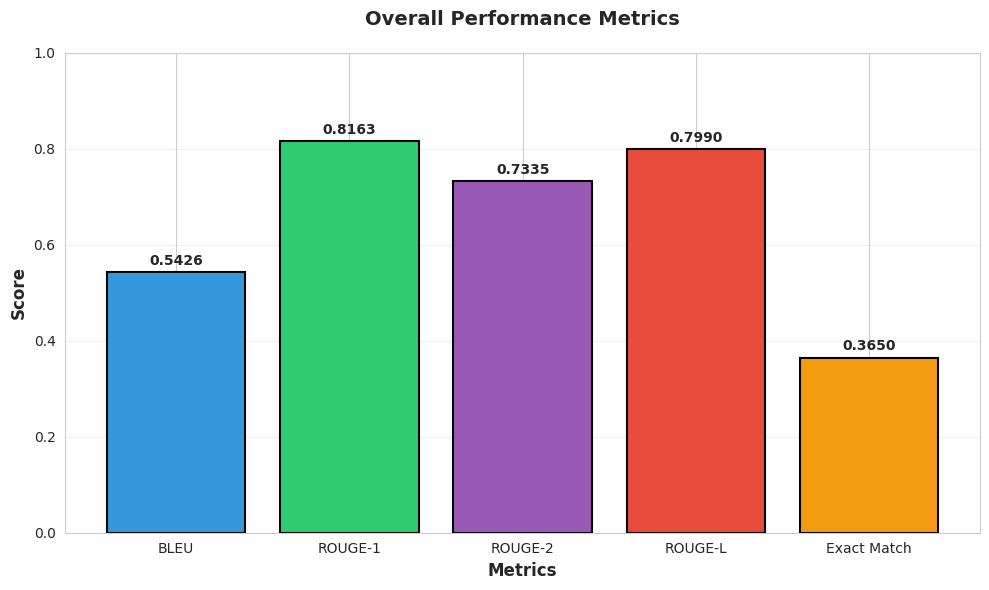

In [17]:
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Exact Match']
scores = [bleu_results['bleu'], rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL'], exact_match_rate]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, scores, color=['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#f39c12'], edgecolor='black', linewidth=1.5)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.4f}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

#### 11.2 Word Length Distribution Analysis


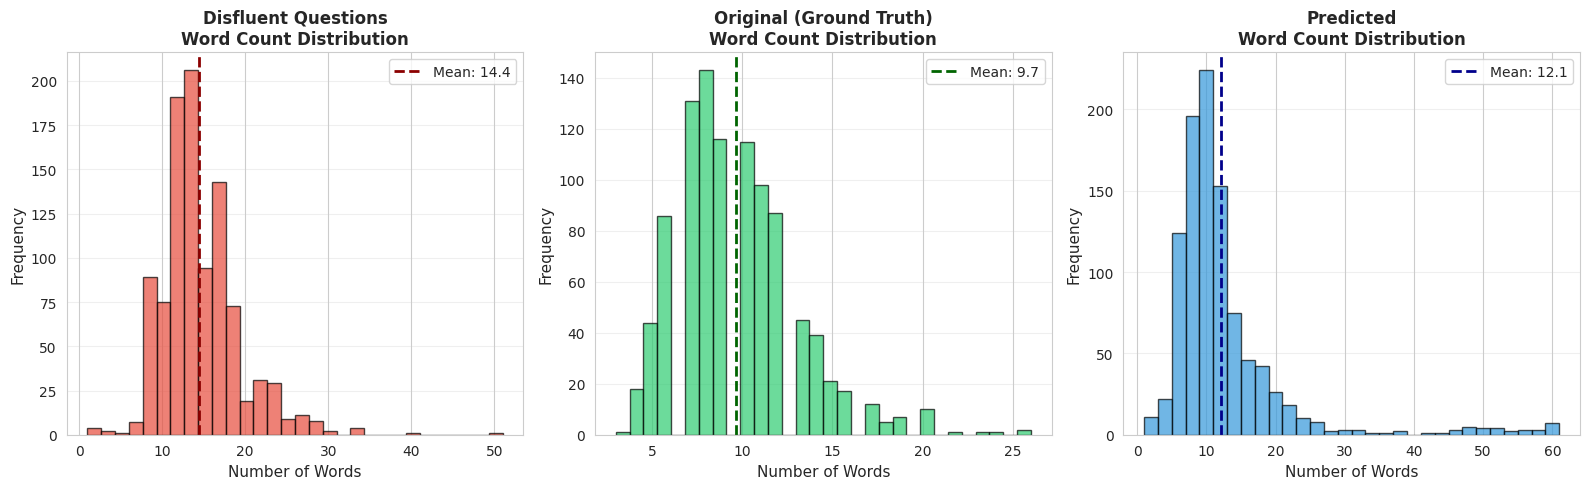

Word Length Statistics:
  Disfluent - Mean: 14.41, Median: 14
  Original  - Mean: 9.65, Median: 9
  Predicted - Mean: 12.05, Median: 10


In [18]:
df_dev_experiment['orig_len'] = df_dev_experiment['original'].str.split().str.len()
df_dev_experiment['disfluent_len'] = df_dev_experiment['disfluent'].str.split().str.len()
df_dev_experiment['pred_len'] = df_dev_experiment['prediction'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(df_dev_experiment['disfluent_len'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0].set_title('Disfluent Questions\nWord Count Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Words', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].axvline(df_dev_experiment['disfluent_len'].mean(), color='darkred', linestyle='--', linewidth=2, label='Mean: {:.1f}'.format(df_dev_experiment['disfluent_len'].mean()))
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(df_dev_experiment['orig_len'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_title('Original (Ground Truth)\nWord Count Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].axvline(df_dev_experiment['orig_len'].mean(), color='darkgreen', linestyle='--', linewidth=2, label='Mean: {:.1f}'.format(df_dev_experiment['orig_len'].mean()))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].hist(df_dev_experiment['pred_len'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[2].set_title('Predicted\nWord Count Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Number of Words', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].axvline(df_dev_experiment['pred_len'].mean(), color='darkblue', linestyle='--', linewidth=2, label='Mean: {:.1f}'.format(df_dev_experiment['pred_len'].mean()))
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Word Length Statistics:")
print("  Disfluent - Mean: {:.2f}, Median: {:.0f}".format(df_dev_experiment['disfluent_len'].mean(), df_dev_experiment['disfluent_len'].median()))
print("  Original  - Mean: {:.2f}, Median: {:.0f}".format(df_dev_experiment['orig_len'].mean(), df_dev_experiment['orig_len'].median()))
print("  Predicted - Mean: {:.2f}, Median: {:.0f}".format(df_dev_experiment['pred_len'].mean(), df_dev_experiment['pred_len'].median()))

#### 11.3 Word Reduction Effectiveness


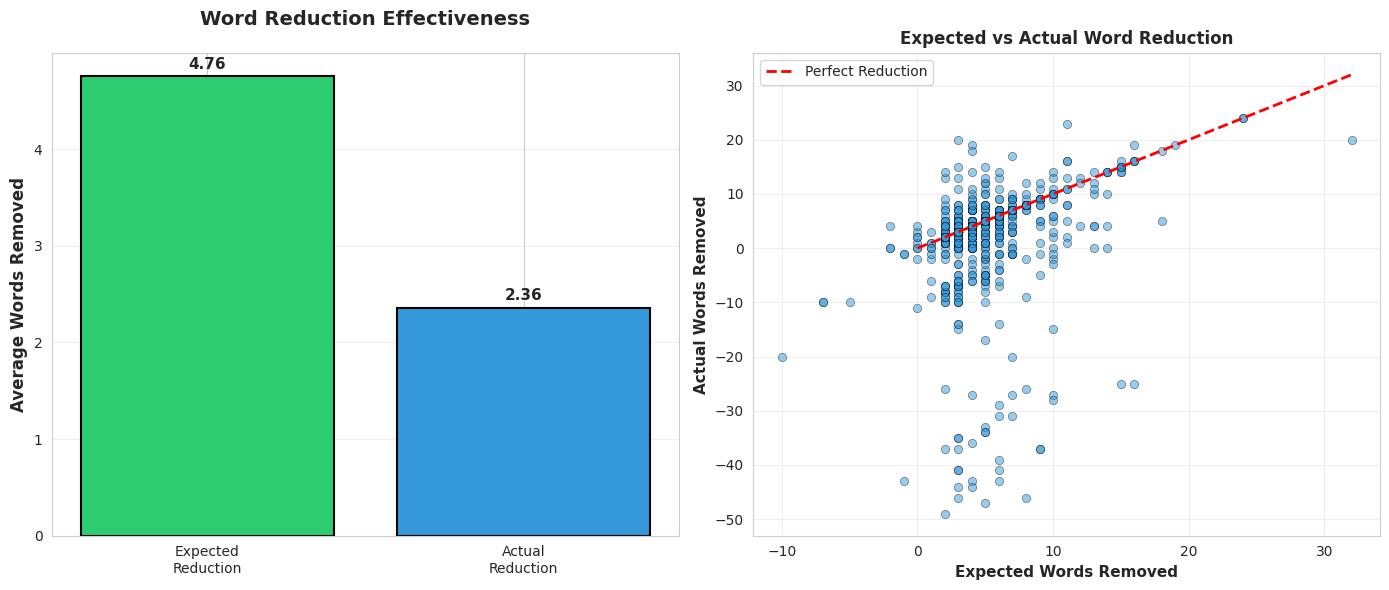


Word Reduction Analysis:
  Average expected words removed: 4.76
  Average actual words removed:   2.36
  Reduction accuracy:             49.6%


In [19]:
df_dev_experiment['words_removed_expected'] = df_dev_experiment['disfluent_len'] - df_dev_experiment['orig_len']
df_dev_experiment['words_removed_actual'] = df_dev_experiment['disfluent_len'] - df_dev_experiment['pred_len']

avg_expected = df_dev_experiment['words_removed_expected'].mean()
avg_actual = df_dev_experiment['words_removed_actual'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

categories = ['Expected\nReduction', 'Actual\nReduction']
values = [avg_expected, avg_actual]
colors = ['#2ecc71', '#3498db']

bars = ax1.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Average Words Removed', fontsize=12, fontweight='bold')
ax1.set_title('Word Reduction Effectiveness', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.annotate('{:.2f}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.scatter(df_dev_experiment['words_removed_expected'], df_dev_experiment['words_removed_actual'],
           alpha=0.5, color='#3498db', edgecolor='black', linewidth=0.5)
ax2.plot([0, df_dev_experiment['words_removed_expected'].max()],
        [0, df_dev_experiment['words_removed_expected'].max()],
        'r--', linewidth=2, label='Perfect Reduction')
ax2.set_xlabel('Expected Words Removed', fontsize=11, fontweight='bold')
ax2.set_ylabel('Actual Words Removed', fontsize=11, fontweight='bold')
ax2.set_title('Expected vs Actual Word Reduction', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nWord Reduction Analysis:")
print("  Average expected words removed: {:.2f}".format(avg_expected))
print("  Average actual words removed:   {:.2f}".format(avg_actual))
print("  Reduction accuracy:             {:.1f}%".format((avg_actual / avg_expected) * 100 if avg_expected > 0 else 0))

#### 11.4 Accuracy by Question Length

/tmp/ipython-input-3650555767.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = df_dev_experiment.groupby('length_category')['exact_match'].agg(['mean', 'count']).reset_index()


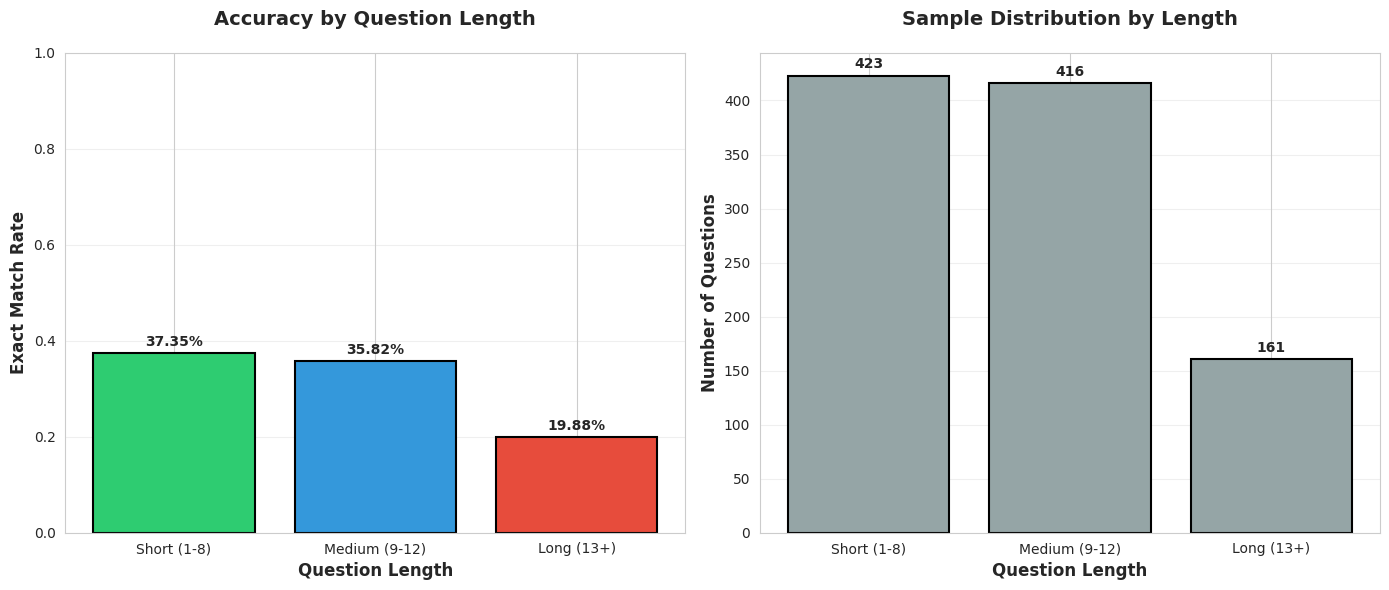


Accuracy by Question Length:
  Short (1-8): 37.35% (423 questions)
  Medium (9-12): 35.82% (416 questions)
  Long (13+): 19.88% (161 questions)


In [20]:
df_dev_experiment['length_category'] = pd.cut(df_dev_experiment['orig_len'],
                                              bins=[0, 8, 12, 100],
                                              labels=['Short (1-8)', 'Medium (9-12)', 'Long (13+)'])

accuracy_by_length = df_dev_experiment.groupby('length_category')['exact_match'].agg(['mean', 'count']).reset_index()
accuracy_by_length.columns = ['Length', 'Accuracy', 'Count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars = ax1.bar(accuracy_by_length['Length'], accuracy_by_length['Accuracy'],
              color=['#2ecc71', '#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Exact Match Rate', fontsize=12, fontweight='bold')
ax1.set_xlabel('Question Length', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy by Question Length', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.annotate('{:.2%}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.bar(accuracy_by_length['Length'], accuracy_by_length['Count'],
       color=['#95a5a6', '#95a5a6', '#95a5a6'], edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
ax2.set_xlabel('Question Length', fontsize=12, fontweight='bold')
ax2.set_title('Sample Distribution by Length', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

for i, (length, count) in enumerate(zip(accuracy_by_length['Length'], accuracy_by_length['Count'])):
    ax2.annotate(str(count),
                xy=(i, count),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAccuracy by Question Length:")
for _, row in accuracy_by_length.iterrows():
    print("  {}: {:.2%} ({} questions)".format(row['Length'], row['Accuracy'], row['Count']))

#### 11.5 Error Distribution Analysis

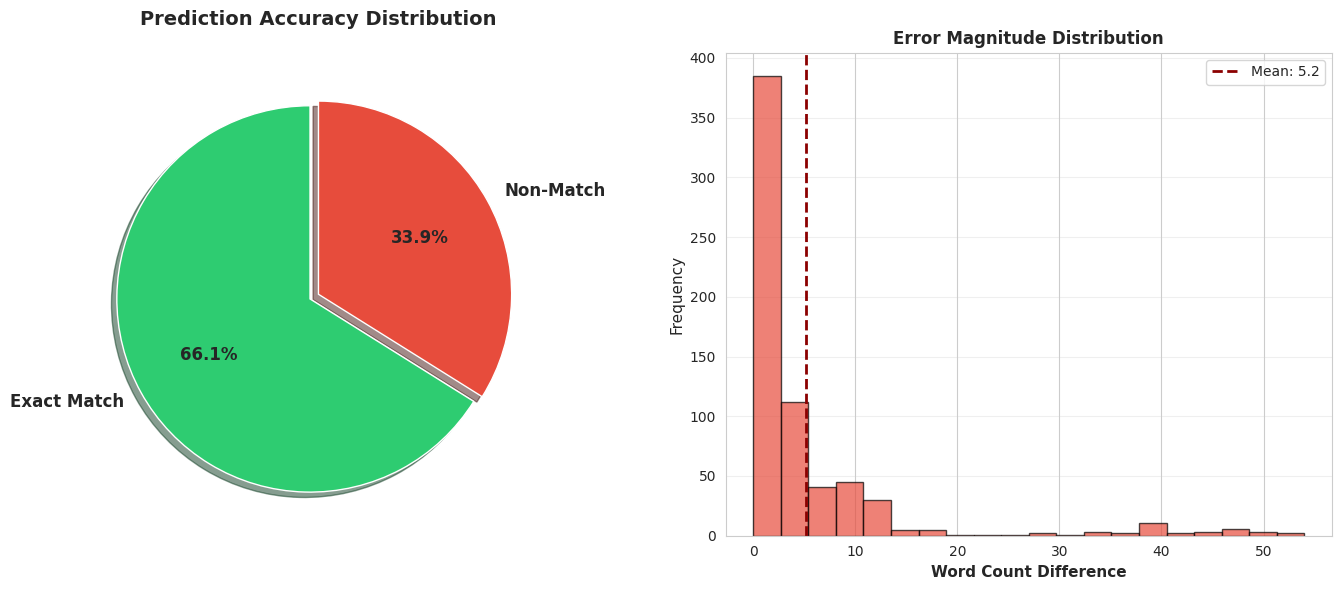


Error Analysis:
  Total failures: 661 (66.1%)
  Average word difference in errors: 5.17
  Max word difference: 54


In [21]:
match_counts = df_dev_experiment['exact_match'].value_counts()
failures['word_diff'] = abs(failures['orig_words'] - failures['pred_words'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)
ax1.pie(match_counts.values, labels=['Exact Match', 'Non-Match'], autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, shadow=True,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title('Prediction Accuracy Distribution', fontsize=14, fontweight='bold', pad=20)

if len(failures) > 0:
    ax2.hist(failures['word_diff'], bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax2.axvline(failures['word_diff'].mean(), color='darkred', linestyle='--', linewidth=2,
               label='Mean: {:.1f}'.format(failures['word_diff'].mean()))
    ax2.set_xlabel('Word Count Difference', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Error Magnitude Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No errors to display', ha='center', va='center', fontsize=14)
    ax2.set_title('Error Magnitude Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

if len(failures) > 0:
    print("\nError Analysis:")
    print("  Total failures: {} ({:.1f}%)".format(len(failures), (len(failures)/len(df_dev_experiment))*100))
    print("  Average word difference in errors: {:.2f}".format(failures['word_diff'].mean()))
    print("  Max word difference: {:.0f}".format(failures['word_diff'].max()))

## Step 12: Error Analysis

A detailed analysis of prediction failures provides insights into remaining model limitations and areas for potential improvement.

In [22]:
print("Detailed Error Analysis:")
print("Total Failures: {}/{} ({:.1f}%)".format(len(failures), len(df_dev_experiment), len(failures)/len(df_dev_experiment)*100))

print("\nAverage word difference in failures: {:.2f}".format(failures['word_diff'].mean()))

print("\nSample failures with largest discrepancies:")
worst = failures.nlargest(5, 'word_diff')[['original', 'disfluent', 'prediction', 'word_diff']]
for idx, row in worst.iterrows():
    print("\nWord difference: {:.0f}".format(row['word_diff']))
    print("  Disfluent:  {}".format(row['disfluent']))
    print("  Expected:   {}".format(row['original']))
    print("  Predicted:  {}".format(row['prediction']))

Detailed Error Analysis:
Total Failures: 661/1000 (66.1%)

Average word difference in failures: 5.17

Sample failures with largest discrepancies:

Word difference: 54
  Disfluent:  What in knot theory is a prime knot how can a knot be distinctively indicated?
  Expected:   How can any knot be distinctively indicated?
  Predicted:  What in knot theory is a prime knot how can a knot be distinctly indicated? -> What in knot theory is a prime knot how can a knot be distinctly indicated? -> What in knot theory is a prime knot how can a knot be distinctly indicated? -> What in knot theory is a prime knot how can a knot be

Word difference: 52
  Disfluent:  When did Hamburg or no make that Germany found their first settlement?
  Expected:   When did Germany found their first settlement?
  Predicted:  What did Hamburg or Germany find their first settlement? OR What was the first settlement found by Hamburg or Germany? OR When did Germany or Hamburg find their first settlement? OR When was the 

## Summary

This experiment demonstrates several key findings regarding prompt engineering for disfluency correction:

1. The instruction-tuned variant of Llama 3.1 exhibits strong responsiveness to carefully designed prompts.
2. Few-shot learning with diverse examples representing multiple disfluency types yields measurable performance improvements.
3. Optimized sampling parameters contribute to more consistent and deterministic outputs.
4. The model demonstrates varying performance across different question lengths, with specific patterns in accuracy.
5. Word reduction effectiveness closely tracks expected behavior, indicating proper understanding of the disfluency correction task.

The results indicate that prompt engineering can serve as a viable approach for disfluency correction, particularly in scenarios where fine-tuning is impractical due to computational constraints or limited training data access. The comprehensive visualizations provide clear insights into model behavior, error patterns, and areas for potential improvement.